In [1]:
from argparse import Namespace
args = Namespace(config='configs/rtdetrv2/rtdetrv2_r18vd_sp1_120e_coco.yml', resume=None, tuning=None, device=None, seed=0, use_amp=True, output_dir=None, summary_dir=None, test_only=False, update=None, print_method='builtin', print_rank=0, local_rank=None)

In [2]:
# COCO classes
CLASSES = [
    'person', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'truck', 'truck', 'boat', 'fire hydrant', 'fire hydrant', 'N/A2',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'cow',
    'sheep', 'cow', 'zebra', 'giraffe', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A3', 'N/A4', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'skateboard', 'sports ball', 'kite', 'baseball bat', 'wine glass',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'bowl', 'wine glass',
    'cup', 'fork', 'orange', 'broccoli', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A6', 'dining table', 'N/A7',
    'N/A8', 'toilet', 'N/A9', 'tv', 'laptop', 'clock', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A10',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [3]:
import torch
import matplotlib.pyplot as plt
import torchvision

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None, classes=CLASSES):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    #unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    #image = unimage
    image = img
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{classes[label.item()]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [4]:
import os
os.chdir("/traindata/maksim/repos/RT-DETR/rtdetrv2_pytorch")
!pwd

/traindata/maksim/repos/RT-DETR/rtdetrv2_pytorch


In [5]:
import os 
import sys 

import argparse

from src.misc import dist_utils
from src.core import YAMLConfig, yaml_utils
from src.solver import TASKS
dist_utils.setup_distributed(args.print_rank, args.print_method, seed=args.seed)

Not init distributed mode.


False

In [6]:
update_dict = yaml_utils.parse_cli(args.update)
update_dict.update({k: v for k, v in args.__dict__.items() \
    if k not in ['update', ] and v is not None})

cfg = YAMLConfig(args.config, **update_dict)
print('cfg: ', cfg.__dict__)

solver = TASKS[cfg.yaml_cfg['task']](cfg)

cfg:  {'task': 'detection', '_model': None, '_postprocessor': None, '_criterion': None, '_optimizer': None, '_lr_scheduler': None, '_lr_warmup_scheduler': None, '_train_dataloader': None, '_val_dataloader': None, '_ema': None, '_scaler': None, '_train_dataset': None, '_val_dataset': None, '_collate_fn': None, '_evaluator': None, '_writer': None, 'num_workers': 0, 'batch_size': None, '_train_batch_size': None, '_val_batch_size': None, '_train_shuffle': None, '_val_shuffle': None, 'resume': None, 'tuning': None, 'epoches': 120, 'last_epoch': -1, 'use_amp': True, 'use_ema': True, 'ema_decay': 0.9999, 'ema_warmups': 2000, 'sync_bn': True, 'clip_max_norm': 0.1, 'find_unused_parameters': False, 'seed': 0, 'print_freq': 100, 'checkpoint_freq': 1, 'output_dir': './output/rtdetrv2_r18vd_sp1_120e_coco', 'summary_dir': None, 'device': '', 'yaml_cfg': {'task': 'detection', 'evaluator': {'type': 'CocoEvaluator', 'iou_types': ['bbox']}, 'num_classes': 80, 'remap_mscoco_category': True, 'train_datalo

In [7]:
solver.train()

Load PResNet18 state_dict


/traindata/maksim/repos/RT-DETR/rtdetrv2_pytorch/src/core/workspace.py:179: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return module(**module_kwargs)


Initial lr: [0.0001, 0.0001]
building train_dataloader with batch_size=16...
loading annotations into memory...
Done (t=23.91s)
creating index...
index created!
building val_dataloader with batch_size=32...
loading annotations into memory...


/traindata/maksim/miniconda3/envs/rtdetrv2/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Done (t=3.57s)
creating index...
index created!


In [8]:
solver.train_dataloader.dataset

Dataset CocoDetection
    Number of datapoints: 118287
    Root location: ./dataset/coco/train2017/
     img_folder: ./dataset/coco/train2017/
     ann_file: ./dataset/coco/annotations/instances_train2017.json
     return_masks: False
     transforms:
       Compose(
          RandomPhotometricDistort(brightness=(0.875, 1.125), contrast=(0.5, 1.5), hue=(-0.05, 0.05), saturation=(0.5, 1.5), p=0.5)
          RandomZoomOut(p=0.5, fill=0, side_range=(1.0, 4.0))
          RandomIoUCrop(min_scale=0.3, max_scale=1, min_aspect_ratio=0.5, max_aspect_ratio=2, options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], trials=40, p=0.8)
          SanitizeBoundingBoxes(min_size=1, min_area=1.0, labels_getter=default)
          RandomHorizontalFlip(p=0.5)
          Resize(size=[640, 640], interpolation=InterpolationMode.BILINEAR, antialias=True)
          SanitizeBoundingBoxes(min_size=1, min_area=1.0, labels_getter=default)
          ConvertPILImage(dtype=float32, scale=True)
          ConvertBoxes(fmt=cxcywh, n

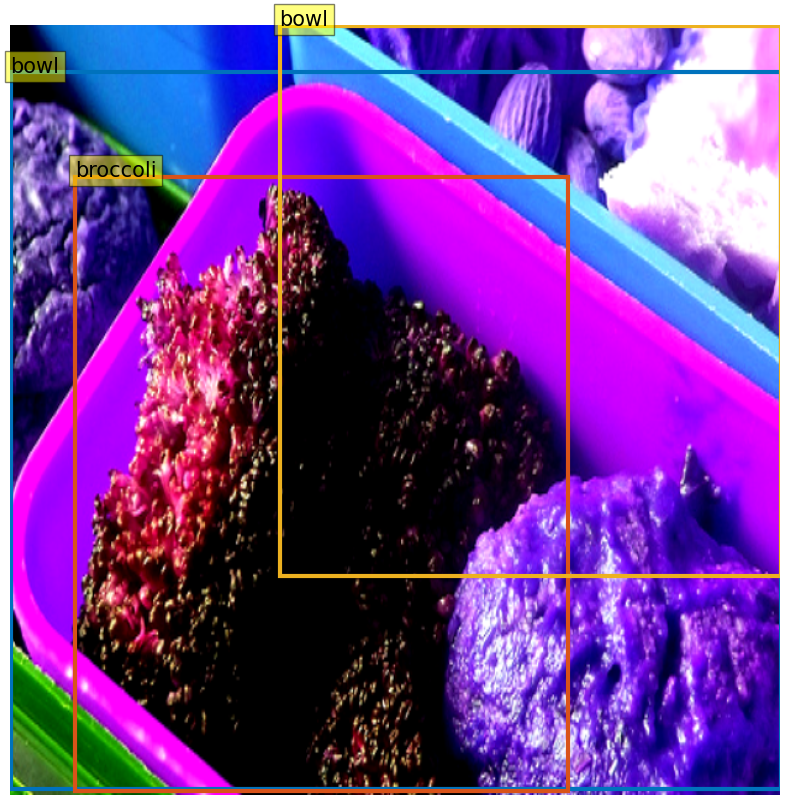

In [9]:
sample = solver.train_dataloader.dataset[0]
plot_results(sample[0], sample[1]["labels"], sample[1]["boxes"], classes=CLASSES)

In [10]:
for batch in solver.train_dataloader:
    break
batch

(tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.00

In [11]:
batch[0].shape

torch.Size([16, 3, 640, 640])

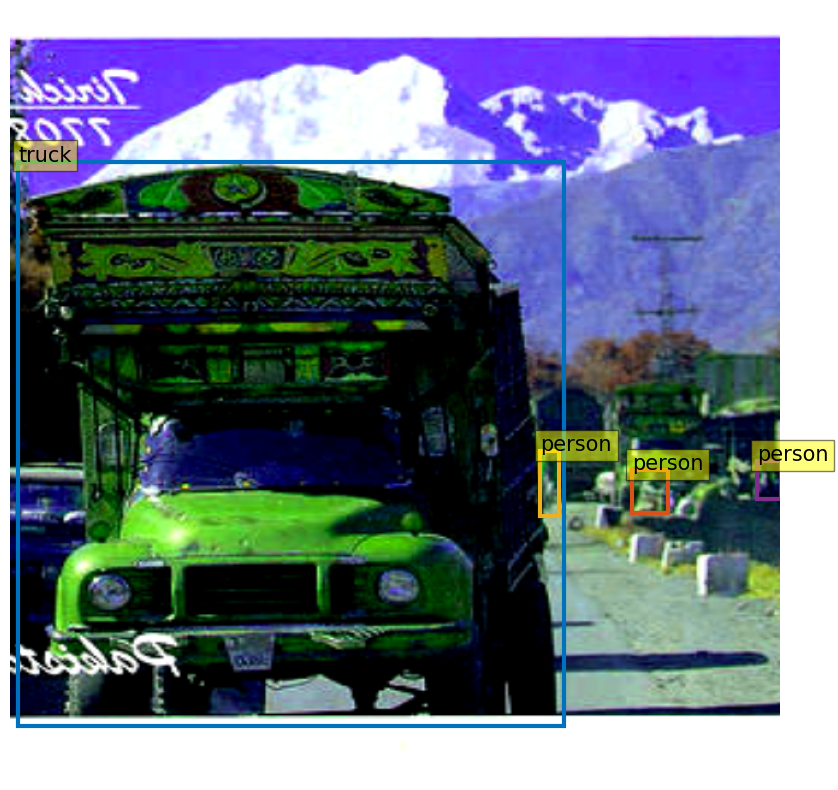

In [12]:
batch_idx = 0
plot_results(batch[0][batch_idx], batch[1][batch_idx]["labels"], batch[1][batch_idx]["boxes"], classes=CLASSES)



In [13]:
solver.criterion

RTDETRCriterionv2(
  (matcher): HungarianMatcher()
)

In [14]:
device = "cuda:0"
sample = batch[0].to(device)
def dic_to_device(dic, device):
    return {k: v.to(device) for k, v in dic.items()}
targets = [dic_to_device(dic, device) for dic in batch[1]]

In [17]:
preds = solver.model(sample, targets)
preds


In [16]:
solver.model

RTDETR(
  (backbone): PResNet(
    (conv1): Sequential(
      (conv1_1): ConvNormLayer(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (conv1_2): ConvNormLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (conv1_3): ConvNormLayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
    )
    (res_layers): ModuleList(
      (0): Blocks(
        (blocks): ModuleList(
          (0): BasicBlock(
            (short): ConvNormLayer(
     